In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy import stats

In [3]:
def train_model(df):

  model1 = linear_model.LinearRegression()
  model3 = linear_model.LassoCV()
  model4 = linear_model.ElasticNet()
  model2 = linear_model.RidgeCV()
  model5 = ensemble.RandomForestRegressor()
  model6 = tree.DecisionTreeRegressor()


  model_list = [model1, model2, model3, model4, model5, model6]

  df = df.dropna(axis=0)

  X = df.drop('price_num', axis=1)
  y = df['price_num']

  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

  categorical_features = X.select_dtypes(include=['object']).columns.tolist()
  numerical_features = X.select_dtypes(include=['number']).columns.tolist()

  preprocessor = ColumnTransformer(transformers=[
        ('cat', preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), categorical_features),
        ('num', preprocessing.StandardScaler() , numerical_features)])

  r2_train = []
  r2_test = []

  RMSE_train = []
  RMSE_test = []

  modelslist = []

  for model in model_list:

    my_pipeline = pipeline.Pipeline([
      ('preprocessor', preprocessor),
      ('model', model),
      ])

    my_pipeline.fit(X_train, y_train)

    y_train_predict = my_pipeline.predict(X_train)
    y_test_predict = my_pipeline.predict(X_test)

    r2_train.append(metrics.r2_score(y_train, y_train_predict))
    r2_test.append(metrics.r2_score(y_test, y_test_predict))

    RMSE_train.append(np.sqrt(((y_train - y_train_predict) ** 2).mean()))
    RMSE_test.append(np.sqrt(((y_test - y_test_predict) ** 2).mean()))



    print(f'{model.__class__.__name__} was finished')


    modelslist.append(model.__class__.__name__)

  metrics_result = pd.DataFrame([[round(num, 2) for num in r2_train],[round(num, 2) for num in r2_test],
   [round(num, 2) for num in RMSE_train], [round(num, 2) for num in RMSE_test] ], index = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test'], columns = modelslist)

  print('***********************\n\n')

  return metrics_result

In [4]:
df_listings = pd.read_csv('/content/drive/MyDrive/UDACITY/Project: Writing a Data Scientist Blog Post/listings.csv')

In [5]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [6]:
#Drop variables that don't have relevant information (in my interpretation)

df_drop = df_listings.drop(['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_location',
 'host_about',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'street',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'smart_location',
 'country_code',
 'amenities',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'license',
 'jurisdiction_names',
 'calculated_host_listings_count',
 'reviews_per_month',
  'host_has_profile_pic',
  'market',
  'country',
  'square_feet'],
                 axis = 1)

In [7]:
#Adjusting values to float and eliminating symbols.
df_drop['price_num'] = df_drop['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_drop['weekly_price_num'] = df_drop['weekly_price'].str.replace('$', '').str.replace(',', '').astype(float)
df_drop['monthly_price_num'] = df_drop['monthly_price'].str.replace('$', '').str.replace(',', '').astype(float)
df_drop['security_deposit_num'] = df_drop['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)
df_drop['cleaning_fee_num'] = df_drop['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)

In [8]:
#converting to decimal rate and eliminating simbols
df_drop['host_response_rate_num'] = df_drop['host_response_rate'].str.replace('%', '').astype(float)/100
df_drop['host_acceptance_rate_num'] = df_drop['host_acceptance_rate'].str.replace('%', '').astype(float)/100

In [9]:
#mapping t/f to binary 1/0
df_drop['host_is_superhost_bin'] = df_drop['host_is_superhost'].map({'t': 1, 'f': 0})
df_drop['instant_bookable_bin'] = df_drop['instant_bookable'].map({'t': 1, 'f': 0})
df_drop['host_identity_verified_bin'] = df_drop['host_identity_verified'].map({'t': 1, 'f': 0})
df_drop['is_location_exact_bin'] = df_drop['is_location_exact'].map({'t': 1, 'f': 0})
df_drop['require_guest_profile_picture_bin'] = df_drop['require_guest_profile_picture'].map({'t': 1, 'f': 0})
df_drop['require_guest_phone_verification_bin'] = df_drop['require_guest_phone_verification'].map({'t': 1, 'f': 0})

In [10]:
df = df_drop.copy(deep=True)

In [11]:
df.columns[df.isnull().sum() > 0].tolist() #listing the columns with NaN values

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood',
 'property_type',
 'bathrooms',
 'bedrooms',
 'beds',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'weekly_price_num',
 'monthly_price_num',
 'security_deposit_num',
 'cleaning_fee_num',
 'host_response_rate_num',
 'host_acceptance_rate_num']

In [12]:
df.groupby('neighbourhood', dropna=False)['price_num'].agg([pd.Series.mode, 'mean', 'count']).sort_values('mean').head(50)

,mode,mean,count
neighbourhood,,,
Chestnut Hill,"[50.0, 68.0, 75.0, 90.0]",70.750000,4
Mattapan,40.0,72.000000,20
Somerville,"[65.0, 80.0]",93.076923,13
Hyde Park,55.0,93.680000,25
Dorchester,65.0,97.451282,195
Roslindale,75.0,99.160000,50
West Roxbury,100.0,111.342857,35
Allston-Brighton,50.0,114.162088,364
East Boston,99.0,124.059829,117


In [13]:
#STRATEGY for NaN values:
#obserb the groupby table: df.groupby('***feature with NaN***', dropna=False)['price_num'].agg([pd.Series.mode, 'mean', 'count']).sort_values('mean').head(50)
#find the NaN price mode
#find the other price mode that is equal (or close to) NaN price mode and select the value associated
#fill the NaN with the value associated

df['host_response_rate'] = df['host_response_rate'].fillna('97%')
df['host_response_time'] = df['host_response_time'].fillna('within an hour')
df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna('81%')
df['neighbourhood'] = df['neighbourhood'].fillna('South Boston')
df['property_type'] = df['property_type'].fillna('other')
df['bathrooms'] = df['bathrooms'].fillna(0.0)
df['bedrooms'] = df['bedrooms'].fillna(2)
df['beds'] = df['beds'].fillna(1)
#df['weekly_price'] = df['weekly_price'].fillna() discarted!!!
#df['monthly_price'] = df['monthly_price'].fillna() discarted!!!!
df['security_deposit'] = df['security_deposit'].fillna('$100.00')
df['cleaning_fee'] = df['cleaning_fee'].fillna('$0')
#df['weekly_price_num'] = df['weekly_price_num'].fillna() discarted!!!!
#df['monthly_price_num'] = df['monthly_price_num'].fillna() discarted!!!!
df['security_deposit_num'] = df['security_deposit_num'].fillna(100)
df['cleaning_fee_num'] = df['cleaning_fee_num'].fillna(0)
df['host_response_rate_num'] = df['host_response_rate_num'].fillna(0.97)
df['host_acceptance_rate_num'] = df['host_acceptance_rate_num'].fillna(0.81)


In [14]:
df.isnull().sum()

host_since                                 0
host_response_time                         0
host_response_rate                         0
host_acceptance_rate                       0
host_is_superhost                          0
host_verifications                         0
host_identity_verified                     0
neighbourhood                              0
latitude                                   0
longitude                                  0
is_location_exact                          0
property_type                              0
room_type                                  0
accommodates                               0
bathrooms                                  0
bedrooms                                   0
beds                                       0
bed_type                                   0
price                                      0
weekly_price                            2693
monthly_price                           2697
security_deposit                           0
cleaning_f

In [15]:
df_lim = df[df['price_num'] < 750]

#df_lim = df.copy(deep=True)

X=df_lim[[
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'is_location_exact_bin',
 'cleaning_fee_num',
 'property_type',
 'neighbourhood',
 ]]

#X=df_lim[['price_num']]

y=df_lim['price_num']

#y=np.log(df_lim['price_num'])

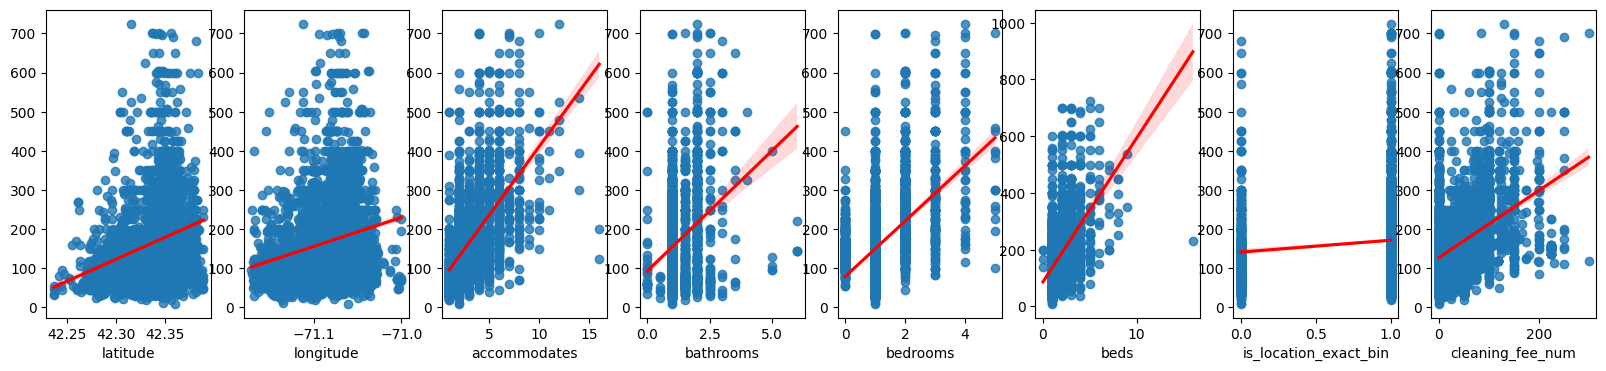

In [16]:
fig, ax = plt.subplots(1,len(X.select_dtypes('number').columns), figsize=(20, 4))
for i, j in enumerate(X.select_dtypes('number').columns):
  sns.regplot(x=df_lim[j], y=y, scatter=True, fit_reg=True, line_kws=dict(color="r"), ax=ax[i])
  ax[i].set_ylabel('')
  #ax[i].set_xlabel(j)
plt.show()

In [17]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
      #('cat', preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), categorical_features),
      ('num', preprocessing.StandardScaler() , numerical_features)])

df_processor = pd.DataFrame(preprocessor.fit_transform(df), columns=[i.replace(' ','_').replace('-', '_').replace('/', '_').replace('&', '_') for i in preprocessor.get_feature_names_out().tolist()])

In [18]:
f =[]
for i in df_processor.columns.tolist():
  f.append(f'{i} + ')

f_cont = ''.join(f)

In [19]:
f_cont

'num__latitude + num__longitude + num__accommodates + num__bathrooms + num__bedrooms + num__beds + num__is_location_exact_bin + num__cleaning_fee_num + '

In [20]:
df_ols = pd.concat([df_processor, y], axis=1)

ols_formula = f'price_num ~ {f_cont[:-3]}'

OLS = ols(formula = ols_formula, data = df_ols)
model = OLS.fit()
model_results = model.summary()
display(model_results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_num   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     364.7
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:29:59   Log-Likelihood:                -20649.
No. Observations:                3565   AIC:                         4.132e+04
Df Residuals:                    3556   BIC:                         4.137e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    167.9406      1.330    126.280      0.000     165.333     170.548
num__latitude                 19.8065      1.419     13.956      0.000      17.024      22.589
num__longitude                11.4846      1.412      8.132      0.000       8.716      14.254
num__accommodates             37.5652      2.541     14.781      0.000      32.582      42.548
num__bathrooms                 7.2998      1.489      4.901      0.000       4.380      10.220
num__bedrooms                 20.2935      2.090      9.708      0.000      16.195      24.392
num__beds                     -3.1282      2.418     -1.294      0.196      -7.868       1.612
num__is_location_exact_bin     3.8082      1.350      2.822      0.005       1.162       6.454
num__cleaning_fee_num         19.4228      1.489     13.040      0.000      16.502      22.343
==============================================================================
Omnibus:                     1025.254   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4557.810
Skew:                           1.328   Prob(JB):                         0.00
Kurtosis:                       7.861   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
summary_table = model.summary2().tables[1]
summary_df_t1 = pd.DataFrame(summary_table)
round(summary_df_t1,1)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,167.9,1.3,126.3,0.0,165.3,170.5
num__latitude,19.8,1.4,14.0,0.0,17.0,22.6
num__longitude,11.5,1.4,8.1,0.0,8.7,14.3
num__accommodates,37.6,2.5,14.8,0.0,32.6,42.5
num__bathrooms,7.3,1.5,4.9,0.0,4.4,10.2
num__bedrooms,20.3,2.1,9.7,0.0,16.2,24.4
num__beds,-3.1,2.4,-1.3,0.2,-7.9,1.6
num__is_location_exact_bin,3.8,1.3,2.8,0.0,1.2,6.5
num__cleaning_fee_num,19.4,1.5,13.0,0.0,16.5,22.3


In [22]:
summary_table = model.summary2().tables[0]
summary_df_t0 = pd.DataFrame(summary_table)
summary_df_t0

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.449
1,Dependent Variable:,price_num,AIC:,41316.3944
2,Date:,2024-06-10 12:30,BIC:,41372.0047
3,No. Observations:,3565,Log-Likelihood:,-20649.
4,Df Model:,8,F-statistic:,364.7
5,Df Residuals:,3556,Prob (F-statistic):,0.00
6,R-squared:,0.451,Scale:,6304.7


In [23]:
#model.pvalues
#model.param

Text(0.5, 1.0, 'Normal Q-Q plot')

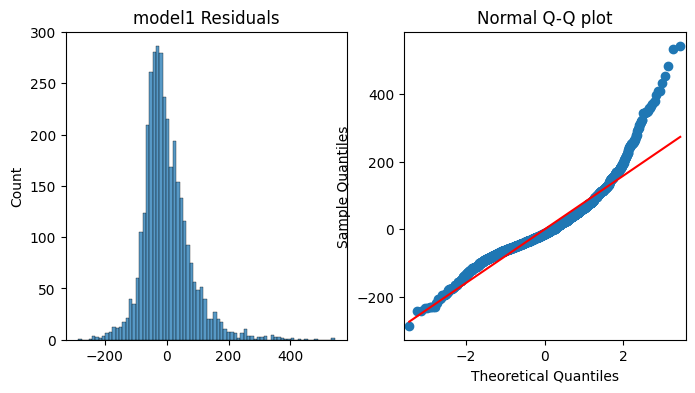

In [24]:
residual = model.resid

fig, axes = plt.subplots(1, 2, figsize = (8,4))

sns.histplot(residual, ax=axes[0])
axes[0].set_title("model1 Residuals")

sm.qqplot(residual, line='s',ax = axes[1])
axes[1].set_title("Normal Q-Q plot")

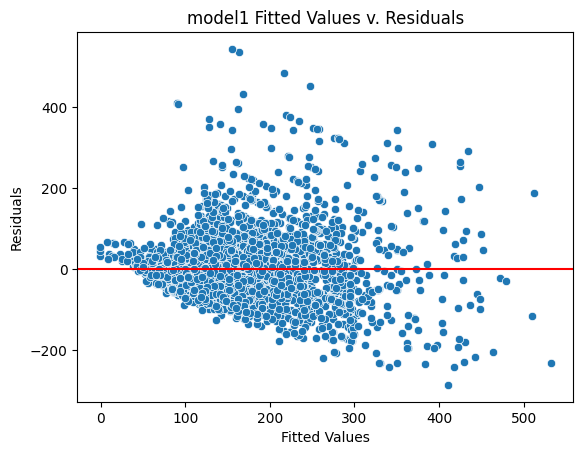

In [25]:
fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("model1 Fitted Values v. Residuals")
fig.axhline(0, color='red')
plt.show()

In [26]:
train_model(df_lim.drop(['host_since'], axis=1))

LinearRegression was finished
RidgeCV was finished
LassoCV was finished
ElasticNet was finished
RandomForestRegressor was finished
DecisionTreeRegressor was finished
***********************




,LinearRegression,RidgeCV,LassoCV,ElasticNet,RandomForestRegressor,DecisionTreeRegressor
R2_train,1.00,0.93,0.90,0.83,0.98,1.00
R2_test,0.75,0.85,0.84,0.83,0.82,0.57
RMSE_train,0.00,25.96,32.60,41.47,15.18,0.00
RMSE_test,50.66,38.63,39.73,41.72,42.55,66.02
